# $F=0 \rightarrow F'=1$ MOT forces

This example covers calculating the textbook example of forces in a one-dimensional MOT with an $F=0\rightarrow F'=1$ atom.  We will focus on two governing equations: the `heuristic` equation and the `rateeq`.  In this example, we'll calculate the forces using both and compare.  We will also calculate the trapping frequencies and damping coefficients as well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts

### Choose the units

Whatever units we use, let's run numbers that are realistic for a common atom, Rb.:

In [2]:
rb87 = atom('87Rb')

klab = 2*np.pi*rb87.transition[1].k # Lab wavevector (without 2pi) in cm^{-1}
taulab = rb87.state[2].tau  # Lifetime of 6P_{3/2} state (in seconds)
gammalab = 1/taulab 
Blab = 15 # About 15 G/cm is a typical gradient for Rb

print(klab, taulab, gammalab/2/np.pi)

80528.75481555492 2.62348e-08 6066558.277246076


As with any problem in `pylcp`, the units that one chooses are arbitrary.  We will denote all explicit units with a subscript and all quantities where we have removed the units with an overbar, e.g. $\bar{x} = x/x_0$.  Our choice in this script will be different from the default choices of $x_0=1/k$ and $t_0 =1/\Gamma$.  Let's try a system where lengths are measured in terms of $x_0 = \hbar\Gamma/\mu_B B'$ and $t_0 = k x_0/\Gamma$.  This unit system has the advantage that it measures lengths in terms of Zeeman detuning in the trap.  Moreover, velocities are measured in $\Gamma/k$.  Namely,

$$
v = \bar{v} \frac{x_0}{t_0} = \bar{v} \frac{\Gamma}{k}
$$

From the documentation, the consistent mass scale is

$$
\bar{m} = m\frac{x_0^2}{\hbar t_0}
$$

```
# Now, here are our `natural' length and time scales:
x0 = cts.hbar*gammalab/(cts.value('Bohr magneton')*1e-4*15) # cm
t0 = klab*x0*taulab # s
mass = 87*cts.value('atomic mass constant')*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = 1.0*gamma     # The magnetic field gradient parameter

print(x0, t0, mass, k, gamma, alpha)
```

Alternatively, we can just use the default unit system:

In [3]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = taulab  # s

mass = 87*cts.value('atomic mass constant')*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*1e-4*15*x0*t0/cts.hbar

print(x0, t0, mass, k, gamma, alpha)

1.2417924532552691e-05 2.62348e-08 805.2161255642717 1.0 1.0 4.297436175809039e-05


It turns out there is another choice of units, useful in the next example, 
that works extremely well if the radiative force is the *only* force.

### Define the problem

One has to define the Hamiltonian, laser beams, and magnetic field.

In [4]:
# Define the atomic Hamiltonian:
Hg, mugq = pylcp.hamiltonians.singleF(F=0, muB=1)
He, mueq = pylcp.hamiltonians.singleF(F=1, muB=1)

dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

det = -4.
s = 1.5

# Define the laser beams:
laserBeams = pylcp.laserBeams(
    [{'kvec':k*np.array([1., 0., 0.]), 's':s, 'pol':-1, 'delta':det*gamma},
     {'kvec':k*np.array([-1., 0., 0.]), 's':s, 'pol':-1, 'delta':det*gamma}],
    beam_type=pylcp.infinitePlaneWaveBeam
)

# Define the magnetic field:
linGrad = pylcp.magField(lambda R: -alpha*R)

### Define both governing equations

We'll add in the OBEs in a later example.

In [5]:
rateeq = pylcp.rateeq(laserBeams, linGrad, ham, include_mag_forces=True)
heuristiceq = pylcp.heuristiceq(laserBeams, linGrad, gamma=gamma, k=k, mass=mass)

### Calculate equilibrium forces
Let's define both positions and velocities and calculate the forces in the resulting 2D phase space

In [6]:
x = np.arange(-30, 30, 0.4)/(alpha/gamma)
v = np.arange(-30, 30, 0.4)

X, V = np.meshgrid(x, v)

Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)
heuristiceq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)

Completed in 16.61 s.                                               
Completed in 4.26 s.                                               


Now let's plot it up, and compare to the heuristic force equation for this geometry, which is given by

$$
f = \frac{\hbar k\Gamma}{2}\left(\frac{s}{1+2s +4(\Delta - k v - \mu_B B' x/\hbar)^2/\Gamma^2} - \frac{s}{1+2s +4(\Delta + k v + \mu_B B' x/\hbar)^2/\Gamma^2}\right).
$$

where $s = I/I_{\rm sat}$.  Note that the quadrupole field parameter defined above $\alpha = \mu_B B'/\hbar$

No matter what unit system we use above, we want to measure lengths in terms of the magnetic field.  Dividing by the field gradient is enough to accomplish that:

Text(0, 0.5, '$v/(\\Gamma/k)$')

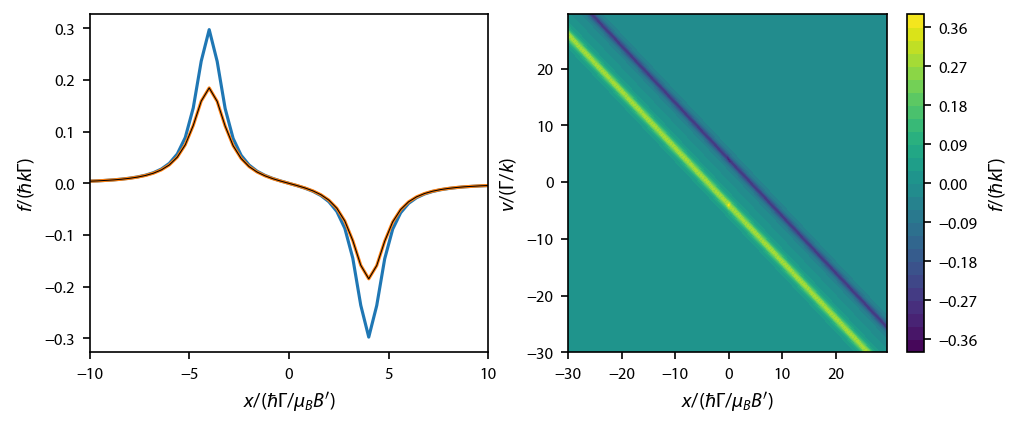

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, num="Expression", figsize=(6.5, 2.75))

ax[0].plot(x*(alpha/gamma), rateeq.profile['Fx'].F[0, int(np.ceil(x.shape[0]/2)), :]/gamma/k)
ax[0].plot(x*(alpha/gamma), heuristiceq.profile['Fx'].F[0, int(np.ceil(x.shape[0]/2)), :]/gamma/k)
ax[0].plot(x*(alpha/gamma), (s/(1+2*s + 4*(det-alpha*x/gamma)**2) - s/(1+2*s + 4*(det+alpha*x/gamma)**2))/2, 'k-', linewidth=0.5)
ax[0].set_ylabel('$f/(\hbar k \Gamma)$')
ax[0].set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax[0].set_xlim((-10, 10))

im1 = ax[1].contourf(X*(alpha/gamma), V, rateeq.profile['Fx'].F[0]/gamma/k, 25)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$f/(\hbar k \Gamma)$')
ax[1].set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax[1].set_ylabel('$v/(\Gamma/k)$')

Note that heuristic equation produces less force at resonance in $x$, because it is over-estimating the total saturation.

### Compute the trap frequencies and damping rates

And we can compare to simple 1D theory.  Let's take the force equation above and expand it about $x=0$ and $v=0$.  We get

$$
f \approx \frac{\hbar k}{2\Gamma}\left(\frac{s \Delta}{1+2s + 4\Delta^2/\Gamma^2}\right)\left( \frac{\mu_B B'}{\hbar} x + k v\right)
$$

The damping coefficient $\beta$, most easily expressed in units of $\hbar k^2$, and is given by

$$
\frac{\beta}{\hbar k^2} = \frac{8 s \delta}{1 + 2s + 4\delta^2}
$$

where $\delta = \Delta/\Gamma$.  Note that the trapping frequency is defined through 

$$
\ddot{x} - \frac{\beta}{m} \dot{x} + \omega^2 x = 0
$$

and therefore, its square is most easily measured in units of $k \mu_B B'/m$,

$$
\frac{\omega^2}{k \mu_B B'/m} = \frac{8 s \delta}{1 + 2s + 4\delta^2}
$$

Note as well that we defined $\alpha$, the quadrupole field parameter above to be $\alpha = \hbar \mu_B B'$.

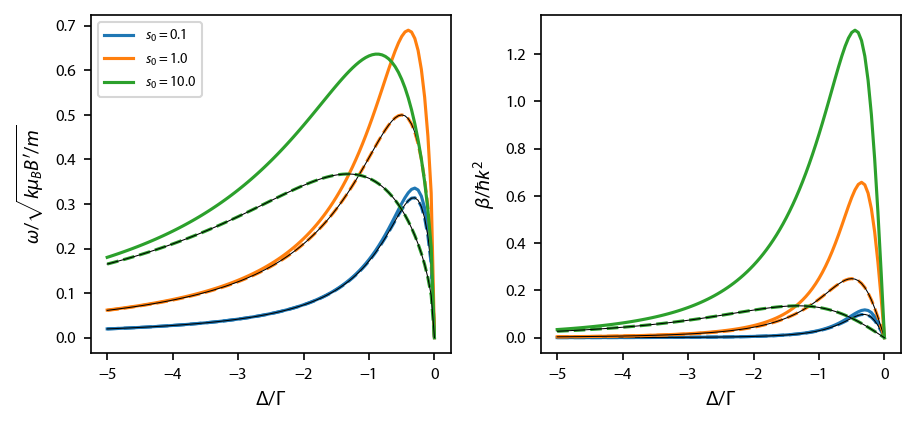

In [8]:
dets = np.arange(-5, 0.05, 0.05)
intensities = np.array([0.1, 1, 10])

omega = np.zeros(intensities.shape + dets.shape)
dampingcoeff = np.zeros(intensities.shape + dets.shape)

omega_heuristic = np.zeros(intensities.shape + dets.shape)
dampingcoeff_heuristic = np.zeros(intensities.shape + dets.shape)

for ii, det in enumerate(dets):
    for jj, intensity in enumerate(intensities):
        # Define the laser beams:
        laserBeams = [None]*2
        laserBeams[0] = pylcp.laserBeam(kvec=k*np.array([1., 0., 0.]), s=intensity,
                                        pol=-1, delta=gamma*det)
        laserBeams[1] = pylcp.laserBeam(kvec=k*np.array([-1., 0., 0.]), s=intensity,
                                        pol=-1, delta=gamma*det)

        rateeq = pylcp.rateeq(laserBeams, linGrad, ham, include_mag_forces=False)
        heuristiceq = pylcp.heuristiceq(laserBeams, linGrad, gamma=gamma, mass=mass)
        
        omega[jj, ii] = rateeq.trapping_frequencies(axes=[0], eps=0.0002)
        dampingcoeff[jj, ii] = rateeq.damping_coeff(axes=[0], eps=0.0002)
        
        omega_heuristic[jj, ii] = heuristiceq.trapping_frequencies(axes=[0], eps=0.0002)
        dampingcoeff_heuristic[jj, ii] = heuristiceq.damping_coeff(axes=[0], eps=0.0002)

fig, ax = plt.subplots(1, 2, figsize=(6, 2.75))
for ii, intensity in enumerate(intensities):
    ax[0].plot(dets, omega[ii]/np.sqrt(k*alpha/mass), '-', color='C{0:d}'.format(ii),
               label='$s_0 = %.1f$'%intensity)
    ax[0].plot(dets, omega_heuristic[ii]/np.sqrt(k*alpha/mass), '--', color='C{0:d}'.format(ii))
    ax[0].plot(dets, np.sqrt(-8*dets*intensity/(1 + 2*intensity + 4*dets**2)**2), 'k-', linewidth=0.5)
    ax[1].plot(dets, dampingcoeff[ii]/k**2, '-', color='C{0:d}'.format(ii))
    ax[1].plot(dets, dampingcoeff_heuristic[ii]/k**2, '--', color='C{0:d}'.format(ii))
    ax[1].plot(dets, -8*dets*intensity/(1 + 2*intensity + 4*dets**2)**2, 'k-', linewidth=0.5)

ax[0].legend(fontsize=7, loc='upper left')
ax[1].set_ylabel('$\\beta/\hbar k^2$')
ax[0].set_ylabel('$\\omega/\sqrt{k \mu_B B\'/m}$')
ax[0].set_xlabel('$\Delta/\Gamma$')
ax[1].set_xlabel('$\Delta/\Gamma$')

fig.subplots_adjust(left=0.08, wspace=0.25)